In [1]:
import numpy as np

import ellipse
from int_field import ZSqrt2Int, ZetaInt
import sr_ipe
import sr_ipy

import matplotlib.pyplot as plt

import search

rationale is as follows:

we begin with some region

enclose it with an ellipse -- note that if we rescale the region it is also easy to rescale the ellipse

Normalize ellipse so that it has determinant 1

we rescale the ellipse so it is upright

find the bounding box (add the point offset to the centered bounding box)

run the ipe algorithm on the bounding box

then, check the generated points and whether they live in the original region 

feed these candidates to norm-solving.



In [2]:
for _ in range(0):
    theta = np.random.rand() * np.pi
    res = search.produce_candidate(theta, 0.9, 1e-5, 15)
    
    assert len(res) > 0, theta

In [3]:
# slightly more challenging angle list:
# 2.126707370682496
# 1.230081192369828

In [21]:
tta = ellipse.make_ellipse_matrix(2.126707370682496, 0.9, 1e-10)

tta

array([[8.01682632e+18, 4.98059673e+18],
       [4.98059673e+18, 3.09428479e+18]])

In [22]:
ttap = tta / np.sqrt(np.linalg.det(tta))
ttap

array([[72244639.730327  , 44883274.46311748],
       [44883274.46311748, 27884536.95736101]])

In [26]:
tta.dtype

dtype('float64')

In [23]:
np.linalg.det(ttap)

0.8073967665097881

In [28]:
K = 35

search.produce_candidate(2.126707370682496, 0.9, 1e-7, K)

skew 5581416152.711215
fixing z + zeta
R
detg:  -2.0
skew 1363014368.5382304
Fixing bias
lf val vs inv 2.414213562373095 0.41421356237309515
fixing z + zeta
A
detg:  1.9999999999999996
skew 22308013.661193293
Fixing bias
lf val vs inv 5.82842712474619 0.1715728752538097
fixing z + zeta
Rb
detg:  -1.999999999999993
skew 9113605.19081043
Fixing bias
lf val vs inv 2.414213562373095 0.41421356237309515
R
detg:  -2.000000000000062
skew 1153527.3298240837
Fixing bias
lf val vs inv 5.82842712474619 0.1715728752538097
fixing beta
fixing z + zeta
B
detg:  -2.000000000000604
skew 194620.8768405571
Fixing bias
lf val vs inv 14.071067811865476 0.0710678118654755
B
detg:  -2.000000000000581
skew 32047.70741888867
Fixing bias
lf val vs inv 14.071067811865476 0.0710678118654755
fixing beta
R
detg:  1.9999999985764279
skew 39.398499283839584
Fixing bias
lf val vs inv 82.01219330881976 0.012193308819760773
fixing z + zeta
B
detg:  -1.9998123982955271
final skew 0.6037651066068456
det=4444449573980017.0

: 

In [5]:
def eval_candidate(real: ZSqrt2Int, imag: ZSqrt2Int, k=20):
    zetaval = real.to_zeta() + ZetaInt((0, 0, 1, 0)) * imag.to_zeta()
    
    print(f"Angle has value: {np.angle(zetaval.eval())}")
    
    re = zetaval * ~zetaval
    re, _ = zetaval.to_zsq()
    
    xi = ZSqrt2Int((16 * 2**k, 0)) - re
    assert xi.eval() > 0
    print(f"Factorizing xi = {xi}")
    print(sr_ipy.factorize_xi(xi))

In [6]:
eval_candidate(ZSqrt2Int((362, -1708)), ZSqrt2Int((-13934, 12190)))

Angle has value: 2.1267123503568235
Factorizing xi = ZSqrt2Int((16776854, 1708))
finding non-residue
beginning search
finding non-residue
beginning search
70365706075696 4397856629731 1
[(ZetaInt((0, 1, 0, -1)), 1), (ZetaInt((-8684, -5895, -225, 5693)), 1), (ZetaInt((-1, 1, 0, -1)), 2)]


In [5]:
np.angle(0.6582638344965545+0.6862548471372333j)

0.8062137683940437

In [6]:
def make_ellipse_matrix(theta, q, eps):
    a, b, c, d, e, f = find_coefficients(0, 0, theta, (1-q)/2, 6 * np.arcsin(eps / 2))
    
    # so that Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0
    # D, E = 0 so 
    # Ax^2 + Bxy + Cy^2 = -F
    # -A/F x^2 - B/F xy - C/F y^2 = 1
    
    return np.array([[a, b/2], [b/2, c]]) / -f

def make_ellipse_center(theta, q):
    mid_distance = (1 - q)/2 + q
    x0 = mid_distance * np.cos(theta)
    y0 = mid_distance * np.sin(theta)
    
    return x0, y0

def ellipse_mat_val(x, y, mat):
    u = np.array([[x, y]]).T
    return u.T @ mat @ u
    

def ellipse_val(x, y, a, b, c, d, e, f):
    return a*x**2 + b*x*y + c*y**2 + d*x + e*y + f

def find_coefficients(x0, y0, theta, a, b):
    # x0, y0 are the center of the ellipse
    # theta is the angle of rotation
    # a, b are the semi-major and semi-minor axes
    # returns the coefficients of the ellipse equation
    # a*x^2 + b*x*y + c*y^2 + d*x + e*y + f = 0
    
    # first we need to rotate the ellipse
    A = a**2 * np.sin(theta)**2 + b**2 * np.cos(theta)**2
    B = 2*(b**2 - a**2) * np.sin(theta) * np.cos(theta)
    C = a**2 * np.cos(theta)**2 + b**2 * np.sin(theta)**2
    D = -2*A*x0 - B*y0
    E = -B*x0 - 2*C*y0
    F = A*x0**2 + B*x0*y0 + C*y0**2 - a**2*b**2
    
    return A, B, C, D, E, F

def check_in_region(x, q, theta, eps):
    if np.abs(x) < q or np.abs(x) > 1:
        return False
    if np.angle(x) < theta - eps or np.angle(x) > theta + eps:
        # print(f"angle={np.angle(x)}, theta={theta}, eps={eps}")
        return False
    return True

def compute_bounding_box(ellipse):
    # return w, h
    # see boundingbox code in Haskell
    det = np.linalg.det(ellipse)
    sqrtdet = np.sqrt(det)
    a = ellipse[0,0]
    d = ellipse[1,1]
    
    print(f"det={det}, sqrtdet={sqrtdet}, a={a}, d={d}")
    
    return np.sqrt(d) / sqrtdet, np.sqrt(a) / sqrtdet

In [7]:
theta = 0.8
theta = np.pi/3
theta = 1.230081192369828
theta = 2.126707370682496

q = 0.9
eps = 1e-5

In [8]:

A_ellipse = make_ellipse_matrix(theta, q, eps)
B_ellipse = np.eye(2)

# normalize
a_normalization_factor = np.sqrt(np.linalg.det(A_ellipse))
b_normalization_factor = np.sqrt(np.linalg.det(B_ellipse))
A_ellipse = A_ellipse / a_normalization_factor
B_ellipse = B_ellipse / b_normalization_factor

print(f"Norm: {a_normalization_factor}")

G, Aprime, Bprime = ellipse.find_grid_operator(A_ellipse, B_ellipse)
Ginv = ellipse.compute_ginverse(G)

ellipse.bias(Aprime, Bprime)


Norm: 666666.6666211198
skew 558142.3325181258
fixing z + zeta
R
detg:  -2.0
skew 136301.61200972358
Fixing bias
shift_k negative!!!
lf val vs inv 2.414213562373095 0.41421356237309515
fixing z + zeta
A
detg:  1.9999999999999996
skew 2231.764100722972
Fixing bias
shift_k negative!!!
lf val vs inv 5.82842712474619 0.1715728752538097
fixing z + zeta
Rb
detg:  -1.999999999999993
skew 911.0572313300863
Fixing bias
shift_k negative!!!
lf val vs inv 2.414213562373095 0.41421356237309515
R
detg:  -2.000000000000062
skew 115.30721677708826
Fixing bias
shift_k negative!!!
lf val vs inv 5.82842712474619 0.1715728752538097
fixing beta
fixing z + zeta
B
detg:  -2.000000000000604
skew 19.05222575506901
Fixing bias
shift_k negative!!!
lf val vs inv 14.071067811865476 0.0710678118654755
B
detg:  -2.000000000000581
final skew 3.5413861790089505


6.558121926674586

In [9]:
Aprime

array([[26.29117508, -1.71504402],
       [-1.71504402,  0.14991251]])

In [10]:
def visualize_ellipse(A):
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    
    z_range = np.zeros((len(x_range), len(y_range)))
    
    for i, x in enumerate(x_range):
        for j, y in enumerate(y_range):
            xyval = np.array([[x, y]]).T
            z_range[i, j] = xyval.T @ A @ xyval
    
    return z_range

C:\Users\keepw\AppData\Local\Temp\ipykernel_36440\1370947519.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z_range[i, j] = xyval.T @ A @ xyval


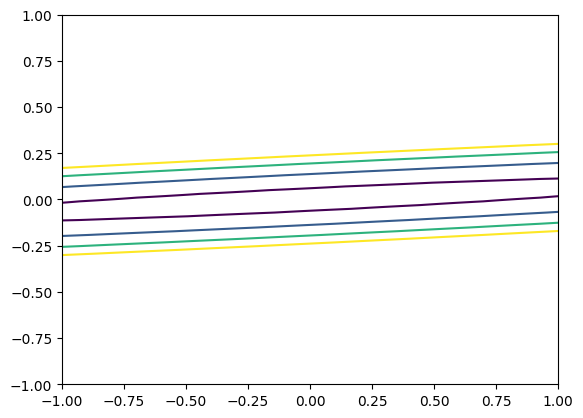

In [11]:
ellipse_vals = visualize_ellipse(Aprime)

# plot contour at 0.5, 1, 1.5
plt.contour(ellipse_vals, levels=[0.1, 0.5, 1, 1.5,], extent=(-1, 1, -1, 1))

In [12]:
orig_A_ellipse = Aprime * a_normalization_factor
orig_B_ellipse = Bprime * b_normalization_factor

wA, hA = compute_bounding_box(orig_A_ellipse)

wB, hB = compute_bounding_box(orig_B_ellipse)

det=444444444422.19354, sqrtdet=666666.6666499785, a=17527450.052477572, d=99941.67151006273
det=1.000000000000007, sqrtdet=1.0000000000000036, a=0.05173182810930901, d=30.928932188134606


In [13]:
wA, hA

(0.00047420329069809193, 0.0062798696340010856)

In [14]:
# we now need to enumerate in the correct range
# note that the x0, y0 offset for the A box is as follows:

a_x0, a_y0 = make_ellipse_center(theta, q)

Gval = ellipse.eval_mat_zsq2(G)

a_x0, a_y0 = Gval @ np.array([a_x0, a_y0])

bb_a_real_min = a_x0 - wA / 2 
bb_a_real_max = a_x0 + wA / 2
bb_a_imag_min = a_y0 - hA / 2
bb_a_imag_max = a_y0 + hA / 2

bb_b_real_min = -wB / 2
bb_b_real_max = wB / 2
bb_b_imag_min = -hB / 2
bb_b_imag_max = hB / 2

In [15]:
k = 20
leader = np.sqrt(2)**k


candidate_transformed = sr_ipy.enumerate_2d(
    leader * bb_a_real_min, 
    leader * bb_a_real_max, 
    leader * bb_a_imag_min, 
    leader * bb_a_imag_max, 
    leader * bb_b_real_min, 
    leader * bb_b_real_max, 
    leader * bb_b_imag_min, 
    leader * bb_b_imag_max)

In [16]:
all_ints = [bb_a_real_min, bb_a_real_max, bb_a_imag_min, bb_a_imag_max, bb_b_real_min, bb_b_real_max, bb_b_imag_min, bb_b_imag_max]
print(all_ints)

[-2714.3850414327735, -2714.384567229483, 4080.1013229089945, 4080.107602778629, -2.7806893114897964, 2.7806893114897964, -0.11372315959085537, 0.11372315959085537]


In [17]:
# let's identify if any meet our critera

ginv_val = ellipse.eval_mat_zsq2(Ginv)

for candidate in candidate_transformed:
    cand_val = candidate.eval()
    orig_val = ginv_val @ np.array([cand_val.real, cand_val.imag]) / leader / (2 * np.sqrt(2))
    
    orig_val = orig_val[0] + 1j * orig_val[1]
    
    # print(f"{np.angle(orig_val)}, {np.abs(orig_val)**2}")
    
    if check_in_region(orig_val, q, theta, eps):
        # we have succeeded!
        print(f"Transformed candidate: {cand_val}")
        
        candsq2 = ZetaInt((0, 1, 0, -1)) * candidate
        
        orig_candsq2 = Ginv @ np.array(candsq2.to_zsq())
        
        # we have picked up an additional sqrt(2) factor from the ginv over the original orig_value
        # so we just need to divide by 4 * leader
        
        print((orig_candsq2[0].eval() + 1j * orig_candsq2[1].eval()) / leader / 4)
        print(orig_val)
        
        print(f"Orig candidate: {orig_candsq2[0], orig_candsq2[1]}")
        
assert 1 == 0 

Transformed candidate: (-2779530.1509333737+4178027.137252547j)
(-0.5013371007161239+0.8069490540351623j)
(-0.5013371016244013+0.8069490540420561j)
Orig candidate: (ZSqrt2Int((362, -1708)), ZSqrt2Int((-13934, 12190)))
Transformed candidate: (-2779529.916914658+4178026.7854848253j)
(-0.5013297023266464+0.8069489814390784j)
(-0.5013297038810083+0.8069489814465209j)
Orig candidate: (ZSqrt2Int((956, -2128)), ZSqrt2Int((-20660, 16946)))
Transformed candidate: (-2779530.2478671+4178027.2829595082j)
(-0.5013401652293853+0.8069490841054445j)
(-0.5013401664684011+0.8069490841124314j)
Orig candidate: (ZSqrt2Int((1796, -2722)), ZSqrt2Int((-30172, 23672)))


AssertionError: 

In [ ]:
ZSqrt2Int((-7948, 5964)).to_zeta() + ZetaInt((0, 0, 1, 0)) * ZSqrt2Int((404, 310)).to_zeta()

ZetaInt((-7948, 6274, 404, -5654))

In [ ]:
np.array([-7948, 6274, 404, -5654]) / 2

array([-3974.,  3137.,   202., -2827.])

In [ ]:
ZetaInt((0, 1, 0, -1)) * ZetaInt((13, -8, 2, 8)) * ZetaInt((49, -37, -118, -145))

ZetaInt((984, 29, -262, 11))

In [ ]:
ZetaInt((984, 29, -262, 11)) * ~ZetaInt((984, 29, -262, 11))

ZetaInt((1037862, 7232, 0, -7232))

In [20]:
eval_candidate(ZSqrt2Int((362, -1708)), ZSqrt2Int((-13934, 12190)))

Angle has value: 2.1267123503568235
Factorizing xi = ZSqrt2Int((16776854, 1708))
finding non-residue
beginning search
finding non-residue
beginning search
70365706075696 4397856629731 1
[(ZetaInt((0, 1, 0, -1)), 1), (ZetaInt((-8684, -5895, -225, 5693)), 1), (ZetaInt((-1, 1, 0, -1)), 2)]


In [ ]:
def quadratic_residue(n, p):
    # find R such that R^2 = c mod p
    # using Tonelli-Shanks
    
    # first, factor p - 1 = q * 2^s
    q = p - 1
    s = 0
    while q % 2 == 0:
        q = q // 2
        s += 1
    
    print("finding non-residue")
    # find a non-residue
    z = 2
    while pow(z, (p-1) // 2, p) == 1:
        z += 1
    
    # initialize
    M = s
    c = pow(z, q, p)
    t = pow(n, q, p)
    r = pow(n, (q + 1) // 2, p)
    
    print("beginning search")
    
    while True:
        if t == 0:
            return 0
        if t == 1:
            return r
        
        i = 1
        while pow(t, (2**i), p) != 1:
            i += 1
            if i == M:
                return None
        
        print(t, q, r)
        assert M - i - 1 >= 0, (M, i)
        b = pow(c, 2**(M-i-1), p)
        
        M = i 
        c = pow(b, 2, p)
        t = (t * pow(b, 2, p)) % p
        r = (r * b) % p

In [ ]:
10000121 % 4

1

In [ ]:
100000037

In [ ]:
quadratic_residue(2, 70365706075697)

finding non-residue
beginning search


49849241413827

In [ ]:
99**2 % 101

4

In [ ]:
# p = 70365706075697
p = 100000000

# need to use the tonelli shanks algorithm to accelerate quadratic residue finding

for k in range(p // 2 + 1):
    if (k**2 + 1) % p == 0:
        print(k)

In [ ]:
eval_candidate(ZSqrt2Int((7118, -4790)), ZSqrt2Int((310, 202)))

NameError: name 'eval_candidate' is not defined

In [ ]:
eval_candidate(ZSqrt2Int((8074, -5466)), ZSqrt2Int((310, 202)))

Angle has value: 1.0472003523199531
Factorizing xi = ZSqrt2Int((516214, 5466))
False


In [ ]:
eval_candidate(ZSqrt2Int((6442, -4312)), ZSqrt2Int((310, 202)))

Factorizing xi = ZSqrt2Int((517846, 4312))


: 

In [ ]:
(ZSqrt2Int((6442, -4312)).eval() + 1j * ZSqrt2Int((310, 202)).eval()) / leader / (2 * np.sqrt(2) * np.sqrt(2))

(0.4749646179760523+0.8226623089215415j)

In [ ]:
ZetaInt((-22376, 18410, 1656, -15986)) * ~ZetaInt((-22376, 18410, 1656, -15986))

ZetaInt((1097908008, -765630752, 0, 765630752))

In [ ]:
ZetaInt((1097908008, -765630752, 0, 765630752)).to_zsq()

(ZSqrt2Int((1097908008, -765630752)), ZSqrt2Int((0, 0)))

In [ ]:
np.abs(ZetaInt((-22376, 18410, 1656, -15986)).eval()) / 4096

0.9500369325689255

In [ ]:
ZSqrt2Int((4096**2, 0)) - ZSqrt2Int((1097908008, -765630752))

ZSqrt2Int((-1081130792, 765630752))

In [ ]:
sr_ipy.factorize_xi(ZSqrt2Int((-1081130792, 765630752)))

False

In [ ]:
assert 1 == 0

AssertionError: 

In [ ]:
ZSqrt2Int((32156, -21362)).eval() + 1j * ZSqrt2Int((1752, 1144)).eval()

(1945.5698805859429+3369.860315354821j)

In [ ]:
(1945.5698805859429+3369.860315354821j) / leader / (2 * np.sqrt(2)) / np.sqrt(2)

(0.4749926466274268+0.8227198035534219j)

In [ ]:
(leader * 2 * 2)**2

16777216.000000045

In [ ]:
ZSqrt2Int((32156, -21362)).to_zeta() + ZSqrt2Int((1752, 1144)).to_zeta() * ZetaInt((0, 0, 1, 0))

ZetaInt((32156, -20218, 1752, 22506))

In [ ]:
ZetaInt((32156, -20218, 1752, 22506)) * ~ZetaInt((32156, -20218, 1752, 22506))

ZetaInt((1952365400, -1369824368, 0, 1369824368))

In [ ]:
ZetaInt((1952365400, -1369824368, 0, 1369824368)).to_zsq()

(ZSqrt2Int((1952365400, -1369824368)), ZSqrt2Int((0, 0)))

In [ ]:
ZSqrt2Int((16777216, 0)) - ZSqrt2Int((1952365400, -1369824368))

ZSqrt2Int((-1935588184, 1369824368))

C:\Users\keepw\AppData\Local\Temp\ipykernel_15840\1370947519.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z_range[i, j] = xyval.T @ A @ xyval


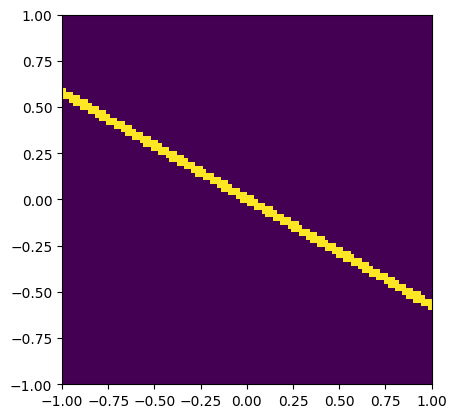

In [ ]:
ellipse_vals = visualize_ellipse(A_ellipse) <= 1


plt.imshow(ellipse_vals, extent=(-1, 1, -1, 1))

C:\Users\keepw\AppData\Local\Temp\ipykernel_15840\1370947519.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z_range[i, j] = xyval.T @ A @ xyval


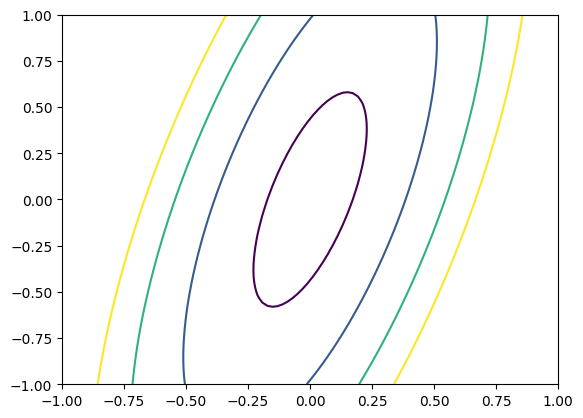

In [ ]:
def enumerate_points(theta, q, eps, k_max):
    # we need to first create the ellipse to bound the point
    # we'll start by creating the ellipse itself and then we can progressively modify the center point
    # as long as we move to a satisfying new grid it will work -- we don't need to always be creating new grid operators (even if we are creating new ellipses, which we don't necessarily need to do)
    
    
    # the ellipse itself is defined as follows
    A_ellipse = ellipse.make_ellipse_matrix(theta, q, eps)
    B_ellipse = np.eye(2)
    
    G, Aprime, Bprime = ellipse.find_grid_operator(A_ellipse, B_ellipse)
    Ginv = ellipse.compute_ginverse(G)
    # the ellipse maker should be making the optimal ellipse and then we choose the axis lengths based on the optimal ellipse    
    
    # create the bounding box for A B
    bb_A_min, bb_A_max = compute_bounding_box(Aprime)
    bb_B_min, bb_B_max = compute_bounding_box(Bprime)
    
    # now, for each value of k, we need to find the points that are within the ellipse
    
    valid_points = []
    for k in range(1, k_max + 1):
        # rescale bounding boxes:
        bb_A_k_min = np.sqrt(2)**k * bb_A_min
        bb_A_k_max = np.sqrt(2)**k * bb_A_max
        
        if k % 2 == 0:
            # k even so signs are the same
            bb_B_k_min = (-np.sqrt(2))**k * bb_B_min
            bb_B_k_max = (-np.sqrt(2))**k * bb_B_max
        else:
            # signs are different
            bb_B_k_min = (-np.sqrt(2))**k * bb_B_max
            bb_B_k_max = (-np.sqrt(2))**k * bb_B_min
        
        # we need to find the points within the ellipse
        k_points = sr_ipy.enumerate_2d(bb_A_k_min, bb_A_k_max, bb_B_k_min, bb_B_k_max)
        
        # TODO: want to add filterability with prior rounds
        
        # temporarily convert $p$ to Z sqrt 2 ints for the next step
        # note that we have ZetaInts right now which may not be expressable as a + bi for a, b in ZSqrt2
        # but, ZetaInts are integers divided by sqrt(2) so we can multiply by sqrt(2) to get Z sqrt 2 ints
        k_points_sqrt2 = [np.array((p * ZetaInt((0, 1, 0, -1))).to_zsq()) for p in k_points]
        
        # need to get types right here -- the points are ZetaInts and we need to remap to zetaints
        # but ginv will be Z sqrt 2 ints
        k_points_true = [Ginv @ p for p in k_points]
        
        # filter for points which are within the ellipse
        k_points = [p for p in k_points if sr_ipy.check_in_region(p.eval(), q, theta, eps)]
        
        # TODO: filter for solvable points
    
    return valid_points

def enumerate_points_k(theta, q, eps, k, A_int, B_int):
    # should output a list of zetaints
    pass


        # adjust by the offset
        # the true center we'd like to use is the point which is (1 + q)/2 away from the origin
        # at angle theta
        true_r = (1 + q)/2
        true_x0 = true_r * np.cos(theta)
        true_y0 = true_r * np.sin(theta)
        
        # which is then rescaled by our k factor
        true_x0 *= np.sqrt(2)**k
        true_y0 *= np.sqrt(2)**k
        
        constant_lambda = 1 + np.sqrt(2)
        half_lambda = constant_lambda / 2
        
        # we need to find a satisfactory point in this interval
        offset_candidates = sr_ipy.enumerate_2d(
            true_x0 - half_lambda, 
            true_x0 + half_lambda, 
            true_y0 - half_lambda, 
            true_y0 + half_lambda, 
            -np.sqrt(2)**k,
            np.sqrt(2)**k,
            -np.sqrt(2)**k,
            np.sqrt(2)**k,
        )
        
        if len(offset_candidates) == 0:
            continue